# Dataset Creation

## Functions

In [54]:
from collections import defaultdict
import os

def get_imagefiles(root):
    images = []
    for root, _, files in os.walk(root):
        for file in files:
            if file.endswith(("jpg", "jpeg", "png")):
                images.append(os.path.join(root, file))
    return images

def validate(images, labels):
    if len(images) != len(labels):
        print(f"Number of images and labels do not match: {len(images)} images, {len(labels)} labels")
        return
    
    images = sorted(images)
    labels = sorted(labels)

    correct, incorrect = [], []
    for img, lbl in zip(images, labels):
        img_name = ".".join(os.path.basename(img).split(".")[:-1])
        lbl_name = ".".join(os.path.basename(lbl).split(".")[:-1])
        if img_name != lbl_name:
            incorrect.append((img, lbl))
        else:
            correct.append((img, lbl))

    if len(incorrect) > 0:
        print(f"Correct: {len(correct)}")
        print(f"Incorrect: {len(incorrect)}")
        return False
    
    return True


def visualize(images, labels, id2label_dict):
    from PIL import Image, ImageDraw, ImageFont
    import matplotlib.pyplot as plt
    import numpy as np
    font = ImageFont.truetype(r"D:\workspace\doc-understanding\assets\MontserratMedium.ttf", size=40)
    
    for img, lbl in zip(images, labels):
        plt.figure(figsize=(10, 10))
        img = Image.open(img)
        lbl = open(lbl, "r", encoding="utf-8").readlines()
        bboxes = [list(map(float, line.split()[1:])) for line in lbl]
        cls = [line.split()[0] for line in lbl]
        draw = ImageDraw.Draw(img)
        for c, bbox in zip(cls, bboxes):
            xc, yc, w, h = bbox
            x1, y1 = int((xc - w/2) * img.width), int((yc - h/2) * img.height)
            x2, y2 = int((xc + w/2) * img.width), int((yc + h/2) * img.height)
            try:
                draw.rectangle([x1, y1, x2, y2], outline="red")
                draw.text((int((x1 + x2)/
                2), int((y1 + y2)/2)),
                        id2label_dict[int(c)], fill="red", font=font)
            except:
                pass
        plt.imshow(np.array(img))
        plt.show()


def get_class_distribution(labels):
    class_dist = defaultdict(int)
    for lbl in labels:
        with open(lbl, "r", encoding="utf-8") as f:
            for line in f.readlines():
                class_dist[line.split()[0]] += 1
    return class_dist

def move_files(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for file in os.listdir(src_dir):
        os.rename(os.path.join(src_dir, file), os.path.join(dst_dir, file))

def merge_train_val_test(root):
    train_dir = os.path.join(root, "train")
    val_dir = os.path.join(root, "val")
    test_dir = os.path.join(root, "test")

    dst_img_dir = os.path.join(root, "images")
    dst_lbl_dir = os.path.join(root, "labels")
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_lbl_dir, exist_ok=True)

    move_files(os.path.join(train_dir, "images"), dst_img_dir)
    move_files(os.path.join(val_dir, "images"), dst_img_dir)
    move_files(os.path.join(test_dir, "images"), dst_img_dir)

    move_files(os.path.join(train_dir, "labels"), dst_lbl_dir)
    move_files(os.path.join(val_dir, "labels"), dst_lbl_dir)
    move_files(os.path.join(test_dir, "labels"), dst_lbl_dir)


def create_all_images_list(baseroot, save=False):
    images = []
    for root, _, files in os.walk(baseroot):
        for file in files:
            if file.endswith(("jpg", "jpeg", "png")):
                images.append(os.path.join(root, file))
    if save:
        savepath = os.path.join(baseroot, "images.txt")
        with open(savepath, "w+") as f:
            for img in images:
                f.write(os.path.relpath(img, baseroot) + "\n")
        return savepath
    return images

def train_val_split(imagelist, dst_dir, val_split=0.1, save=False):
    os.makedirs(dst_dir, exist_ok=True)
    
    import random
    random.seed(111)
    random.shuffle(imagelist)
    
    val_size = int(len(imagelist) * val_split)
    if save:
        trainpath = os.path.join(dst_dir, "train.txt")
        valpath = os.path.join(dst_dir, "val.txt")
        with open(trainpath, "w+") as f:
            for img in imagelist[val_size:]:
                f.write(img if img.endswith("\n") else img + "\n")
        with open(valpath, "w+") as f:
            for img in imagelist[:val_size]:
                f.write(img if img.endswith("\n") else img + "\n")
        return trainpath, valpath
    return imagelist[:val_size], imagelist[val_size:]


def change_cid(labels_dir, cid_mapping):
    for lbl in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, lbl), "r", encoding="utf-8") as f:
            lines = f.readlines()
        with open(os.path.join(labels_dir, lbl), "w", encoding="utf-8") as f:
            for line in lines:
                cid, *bbox = line.split()
                if cid in cid_mapping.keys():
                    new_cid = cid_mapping[cid]
                else:
                    new_cid = cid

                f.write(f"{new_cid} {' '.join(bbox)}\n")


## Publaynet

In [55]:
import json
import os
from pathlib import Path
from PIL import Image

def json2yolo(jsondict,  dst_dir, local_images=None, save=False):

    
    annot_dict = defaultdict(list)
    for ann in jsondict['annotations']:
        annot_dict[ann["image_id"]].append(ann)

    not_in_local = 0
    res_dict = defaultdict(list)
    local_imagenames = [Path(img).name for img in local_images]
    for info in jsondict['images']:
        if local_imagenames and info["file_name"] not in local_imagenames:
            not_in_local += 1
            continue
        
        image_id = info["id"]
        file_name = info["file_name"]
        img_width = info["width"]
        img_height = info["height"]
        

        annots = []
        for ann in annot_dict[image_id]:
            category_id = ann["category_id"]
            x1, y1, w, h = ann["bbox"]
            xc = (x1 + w/2) / img_width
            yc = (y1 + h/2) / img_height
            w /= img_width
            h /= img_height
            annots.append(f"{category_id} {xc} {yc} {w} {h}")

        res_dict[file_name] = annots

    if save:
        os.makedirs(dst_dir, exist_ok=True)
        for img, lbl in res_dict.items():
            with open(os.path.join(dst_dir, img.replace("jpg", "txt").replace("png", "txt").replace("jpeg", "txt")), "w+") as f:
                f.write("\n".join(annots))

    print("Not in local:", not_in_local)
    
    return res_dict

root = r"X:\doc_layout_analysis\publaynet"
annpath = os.path.join(root, "labels_json", "train.json")
labels_dir = os.path.join(root, "labels")
annotations = json.load(open(annpath, "r"))
imagefiles = get_imagefiles(root)
labels_dict = json2yolo(annotations, labels_dir, local_images=imagefiles, save=True)
len(labels_dict)

Not in local: 287745


47958

In [56]:
# for img, lbl in labels_dict.items():
#     with open(os.path.join(labels_dir, img.replace(".jpg", ".txt").replace(".png", ".txt").replace(".jpeg", ".txt")), "w+") as f:
#         f.write("\n".join(lbl))

In [57]:
class_dist = defaultdict(int)
for k, v in labels_dict.items():
    for ann in v:
        class_dist[ann.split()[0]] += 1

id2label = {
    1: "text",
    2: "title",
    3: "list",
    4: "table",
    5: "figure"
}

for k, v in class_dist.items():
    print(f"{id2label[int(k)]:<10}: {v}") 

text      : 334582
table     : 14667
title     : 89467
figure    : 15558
list      : 11564


In [51]:
# Changes TDB
# - title -> text

new_id2label = {
    0: "text",
    1: "table",
    2: "figure",
    3: "list"
}

cid_mapping = {
    "1": "0",
    "2": "0",
    "4": "1",
    "5": "2",
    "3": "3"
}

change_cid(labels_dir, cid_mapping)

text      : 383664


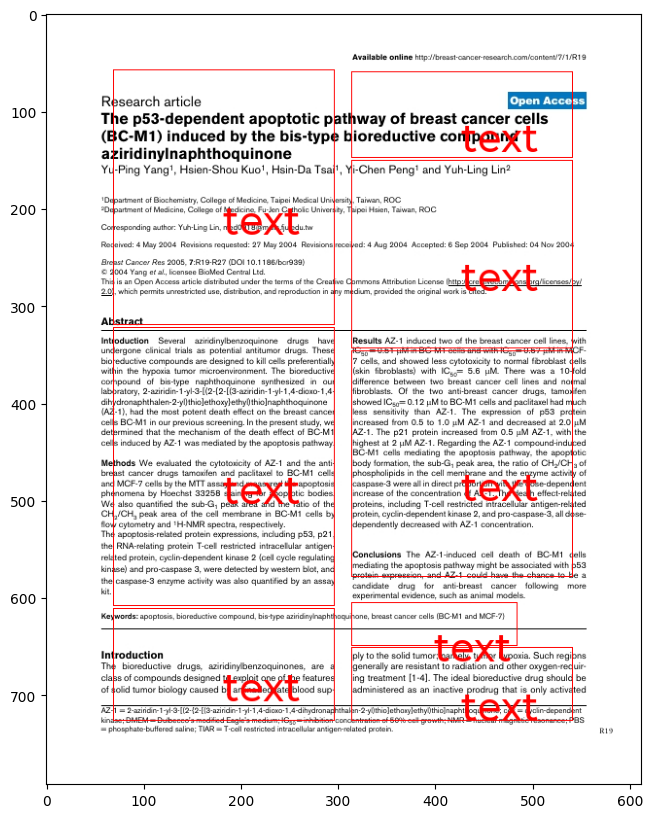

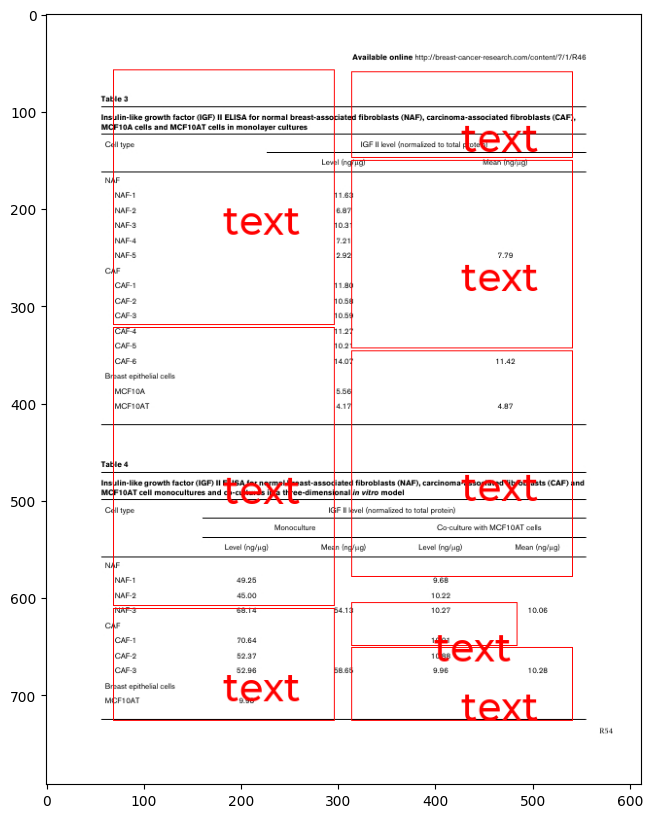

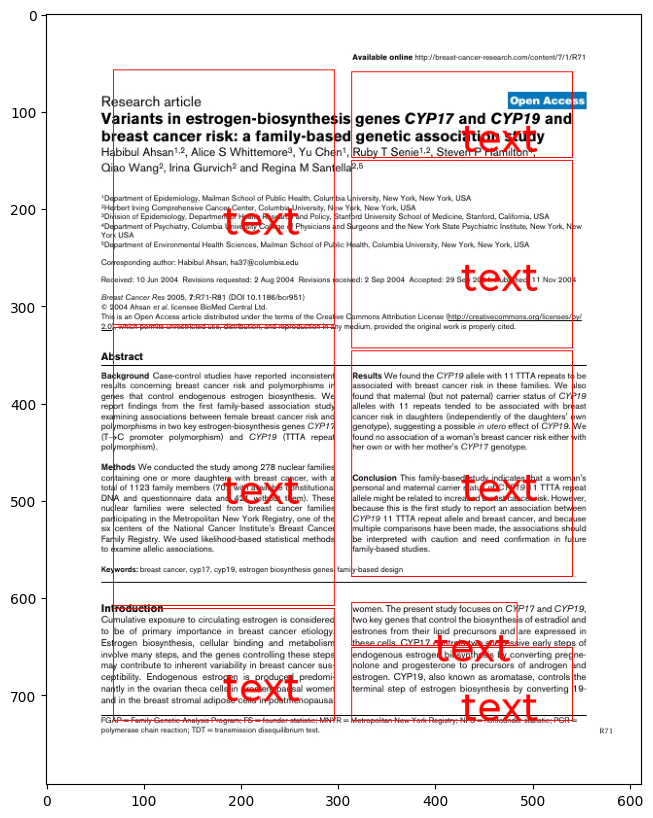

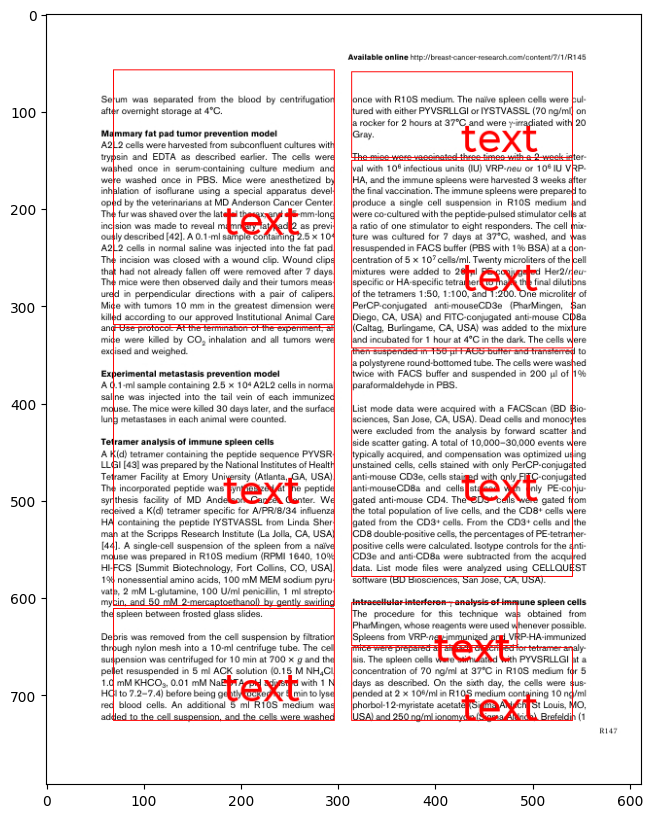

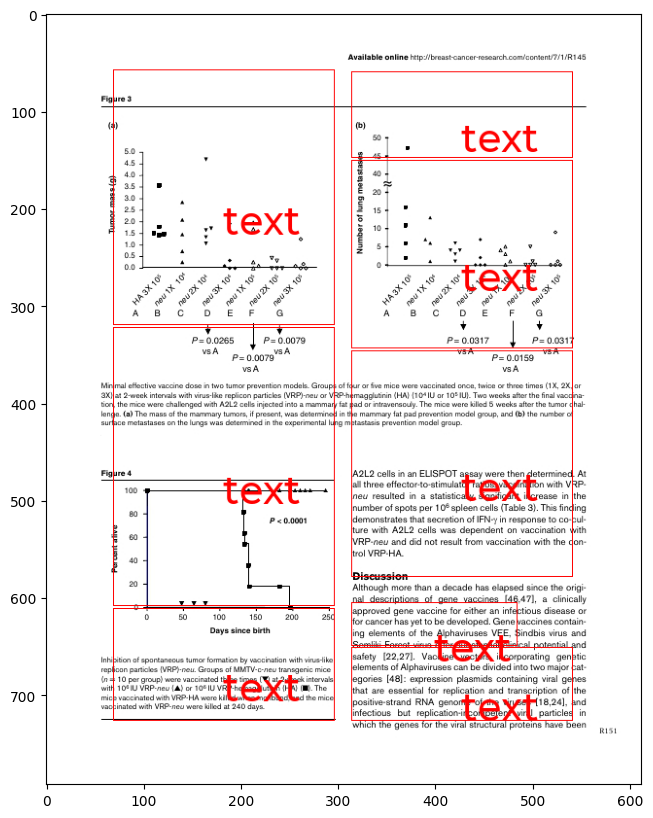

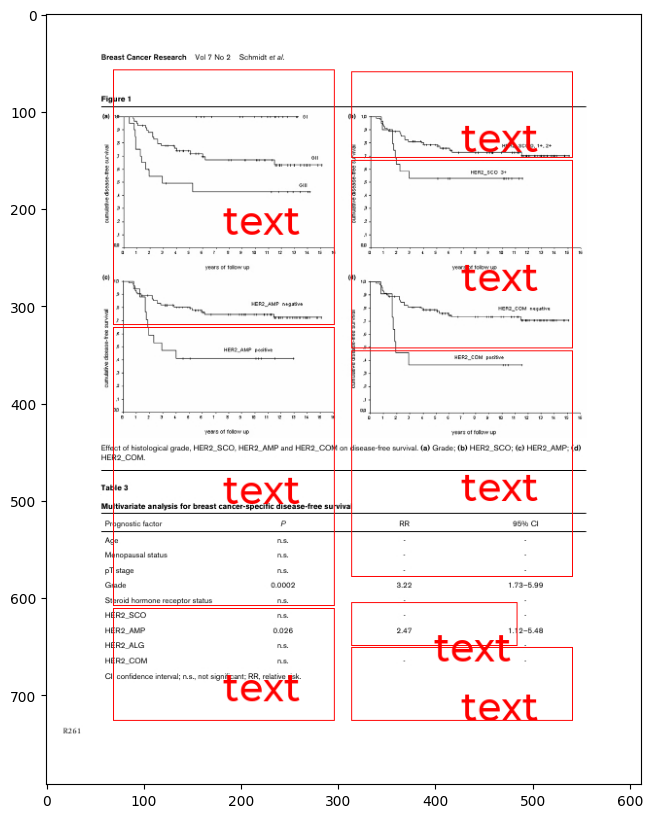

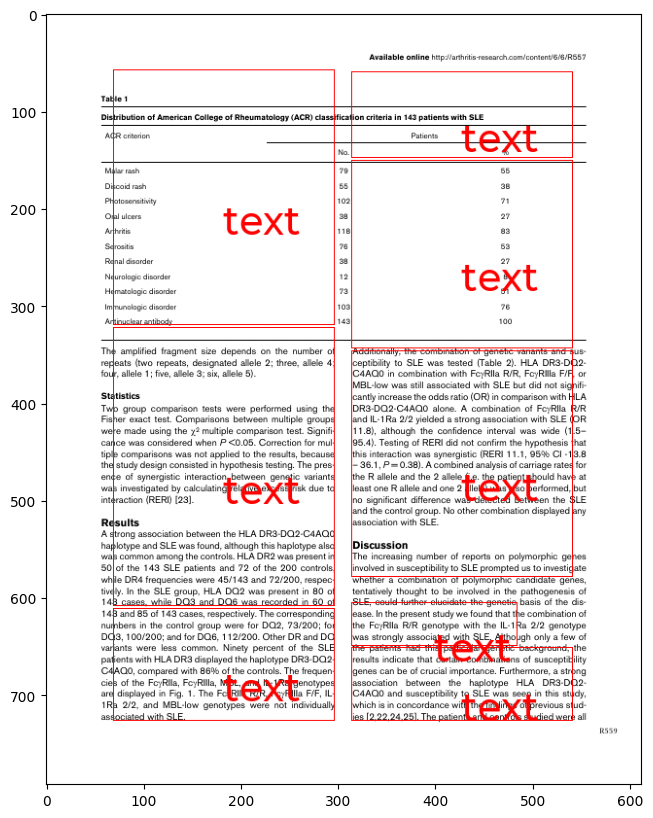

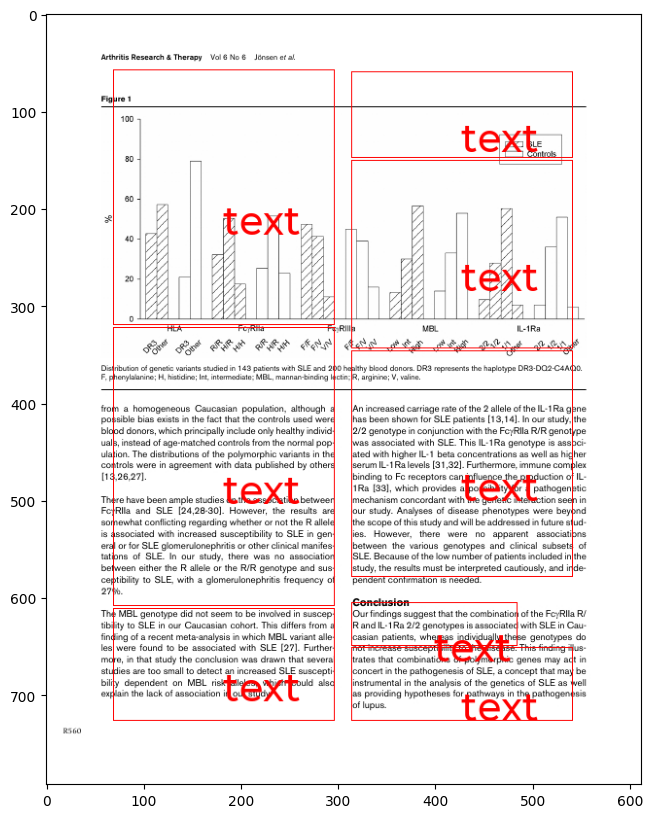

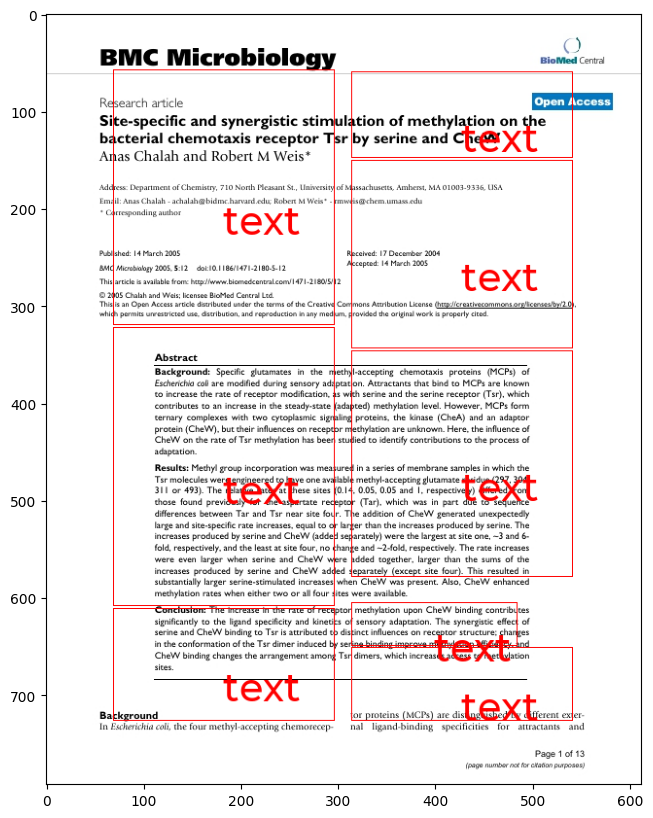

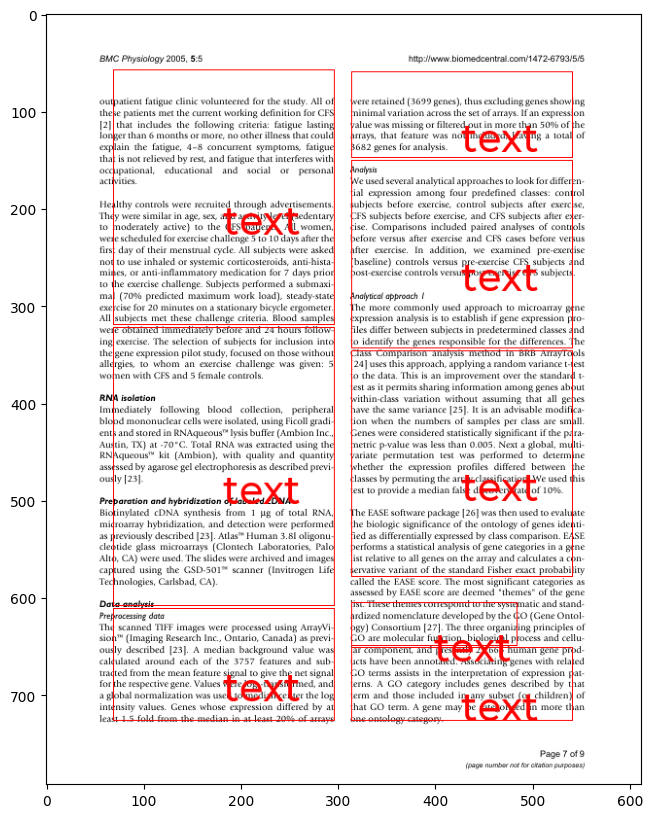

In [52]:
images = get_imagefiles(os.path.join(root, "images"))
labels = [os.path.join(labels_dir, lbl) for lbl in os.listdir(labels_dir) if lbl.endswith(".txt")]
class_dist = get_class_distribution(labels)

for k, v in class_dist.items():
    print(f"{new_id2label[int(k)]:<10}: {v}")

random_images = images[:10]
random_labels = labels[:10]

visualize(random_images, random_labels, new_id2label)

In [53]:
imagelist_path = create_all_images_list(base_root, save=True)
dst_dir = os.path.join(base_root)
imagelist = open(imagelist_path, "r").readlines()
trainlist_path, vallist_path = train_val_split(imagelist, dst_dir, val_split=0.1, save=True)


NameError: name 'base_root' is not defined